In [1]:
import pandas as pd
import spacy
from spacy import displacy
import re
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

NER = spacy.load("en_core_web_sm")

# Step 1. Extract hard-skills

This notebook is only for skills extraction, it includes very few visualizations and explanations. This is done intentionally to separate the actual task from the explanations and descriptions

In [2]:
def prepare_df(df, cols_to_keep=['title', 'company', 'description', 'position']):
    new_df=df[cols_to_keep]
    return new_df

Running the skill extraction process on the full dataset was taking too long so we decided to break the dataset into 3 datasets, extract skills from each of them and then merge the 3 resulting datasets.

In [3]:
df=prepare_df(pd.read_csv('jobs_merged_10k.csv'))
df=df[3500:7000]
df

,title,company,description,position
3500,newJava Developer,FirstVibe Technologies INC.,Java Developer1. 5+ years of hands-on developm...,developer
3501,Entry Level Software Engineer,Enable,Would you like to work in a vibrant environmen...,developer
3502,SQL Developer / Analyst,MCAP,SQL Developer / AnalystMCAP at a GlanceJoining...,developer
3503,Junior Web Developer,VertexOne - Remote US and Canada,"At VertexOne, helping utilities provide the be...",developer
3504,PHP Developer,Vestra Inet,Candidates must have strong experience in back...,developer
...,...,...,...,...
6995,Sr. Full-Stack Developer (Permanent),TES - The Employment Solution,Title: Sr. Developer (Full Stack)\nStatus: Ful...,developer
6996,newSenior Android Developer,Belcan,#wearehiring Belcan Canada Inc. is hiring a Se...,developer
6997,Senior Android Developer,Flexstaf I.T. Inc.,Position: Senior Android DeveloperDuration: ...,developer
6998,newSenior Programmer,Robert Half,"As the Sr. Programmer, you will be working on ...",developer


In [4]:
def del_cont (text): 
    contractions = {"'s":" is", "n't":" not", "'m":" am", "'ve":" have", "'re":" are", "'ll": " will", "’ll":" will"}
    final=text
    for contr, full in contractions.items(): #the method for replacing contractions is retrieved from: https://stackoverflow.com/questions/14156473/can-you-write-a-str-replace-using-dictionary-values-in-python
        final=final.replace(contr, full)
    return final

In [5]:
no_contr=[]
for t in df['description']:
    no=del_cont(t)
    final = re.sub(r"[\n\r]"," ",no)
    no_contr.append(final)

In [6]:
df['description']=no_contr

In [7]:
df.head(5)

,title,company,description,position
3500,newJava Developer,FirstVibe Technologies INC.,Java Developer1. 5+ years of hands-on developm...,developer
3501,Entry Level Software Engineer,Enable,Would you like to work in a vibrant environmen...,developer
3502,SQL Developer / Analyst,MCAP,SQL Developer / AnalystMCAP at a GlanceJoining...,developer
3503,Junior Web Developer,VertexOne - Remote US and Canada,"At VertexOne, helping utilities provide the be...",developer
3504,PHP Developer,Vestra Inet,Candidates must have strong experience in back...,developer


## NER MODEL

In [8]:
stops=['group', 'ontario', 'canada', 'rights', 'salary', 'company', 'operation', 'inc.', 
       'co-op', 'internship', 'startup', 'job', 'career', 'friday',
      'prepare', 'participate', 'diversity', 'hire', 'recruit', 'travel information']

In [9]:
def hard_skills(descr, compName):
    name=compName.lower()
    info=NER(descr)
    raw_skills=[]
    for ent in info.ents:
        if ent.text[0].isupper():
            extracted=ent.text.lower()
            if (ent.label_=='ORG' or ent.label=='PERSON') and extracted not in name and name not in extracted and not any(stop in extracted for stop in stops):
                raw_skills.append(extracted)
    ready_skills=[]
    for skill in raw_skills:
        splitted=re.split('[&,|/]', skill)
        for true_skill in splitted:
            if true_skill not in ready_skills:
                ready_skills.append(true_skill)
    return ready_skills

In [10]:
def add_hard_skills(df):
    hs=[]
    for row in df.itertuples(index=False):
        hs.append(hard_skills(row.description, row.company))
    new_df=df
    new_df['hard_skills']=hs
    return new_df

In [11]:
df_hard=add_hard_skills(df)
df_hard.head(5)

,title,company,description,position,hard_skills
3500,newJava Developer,FirstVibe Technologies INC.,Java Developer1. 5+ years of hands-on developm...,developer,"[core java, java, source control , , sql]"
3501,Entry Level Software Engineer,Enable,Would you like to work in a vibrant environmen...,developer,"[html, css, javascript, gpa, computer science,..."
3502,SQL Developer / Analyst,MCAP,SQL Developer / AnalystMCAP at a GlanceJoining...,developer,"[sql, developer, analyst, ms sql server, ssrs,..."
3503,Junior Web Developer,VertexOne - Remote US and Canada,"At VertexOne, helping utilities provide the be...",developer,"[responsibilitiescode, microsoft, uat, qa, css..."
3504,PHP Developer,Vestra Inet,Candidates must have strong experience in back...,developer,"[mvc, php, apache, light]"


## Skill's preprocessing

In [12]:
skills_arr=np.array(df_hard['hard_skills'])
skills_arr

array([list(['core java', 'java', 'source control ', '', 'sql']),
       list(['html', 'css', 'javascript', 'gpa', 'computer science', ' engineering', ' mathematics', ' physics', 'locationtoronto']),
       list(['sql', 'developer', 'analyst', 'ms sql server', 'ssrs', 'ssis', 'crystal reports', 'application development', 'etl development', 'sap crystal reports', 'waterloo', 'cots']),
       ...,
       list(['onabout', 'java', 'kotlin', 'json', 'j2ee', 'db', 'mks', 'mvc', 'mvvm', 'university or college', 'computer science', 'javascript', 'css', 'html-dom', 'ant', 'maven', 'unix', 'linux', 'android', 'fire tv', 'live']),
       list(['healthcare', 'write', 'javascript', 'aws development', 'lambda', ' elasticsearch', 'ec2', 'sns', 'kinesis developing microservice', 'soa ', ' micro', 'rest services development', 'solid', 'sql', 'sql server', 'html', 'css', 'aws technologies', 'lambda expressions', 'elasticsearch technologies', 'amazon ec2', 'amazon', 'amazon kinesis', 'jira']),
       lis

In [13]:
def flat_2d_arr(arr):
    flat=[]
    for small in arr:
        for element in small:
            flat.append(element)
    return flat

In [14]:
skills_arr=flat_2d_arr(skills_arr)

Now, let's turn our skills into a set to delete repetitions.

In [15]:
set_skills=set(skills_arr)
set_skills

{'',
 'distribution center',
 'lwc',
 'squads',
 'iis ',
 ' android',
 'kpi’s and health ',
 'innovationcontribute',
 'emr exposure',
 'audit',
 'informatica powercenter repository',
 ' mobile',
 'game room',
 'ssrs ',
 'cloud platform',
 'reuters',
 'learning ',
 'sqldw',
 'more patient identification',
 'cb',
 ' data structures',
 'line of service l',
 'customer success',
 'board',
 ' advertising',
 'office environment and plant floor',
 'efficiency ',
 'vodafone',
 'query optimization',
 'harquail centre for neuromodulation',
 'informatica command',
 ' management consulting',
 'brand owner',
 'absence ',
 'winnipeg',
 'function',
 'pos shared services',
 'td bank',
 'rxswift',
 'aws 7+ years',
 'facility location-',
 'telegram',
 'cfl league programs ',
 'trello',
 'athena',
 'front-end development',
 'java developers',
 'devops ',
 'ms excel',
 'planning',
 'branding',
 ' place',
 'intact ventures',
 'department',
 'unity',
 ' safety and wellness',
 'cloud extensive',
 'negative',


Now, let's delete empty entries and trailing whitespaces from the set

In [16]:
better_skills={x.strip() for x in set_skills if (x!='' and (len(x)>1 or x=='r'))}
better_skills={e for e in better_skills if (e!='')}
better_skills

{'distribution center',
 'lwc',
 'squads',
 'innovationcontribute',
 'emr exposure',
 'audit',
 'facelets',
 'informatica powercenter repository',
 'game room',
 'cloud platform',
 'reuters',
 'sqldw',
 'more patient identification',
 'cb',
 'line of service l',
 'malton',
 'receiving',
 'customer success',
 'board',
 'office environment and plant floor',
 'vodafone',
 'query optimization',
 'harquail centre for neuromodulation',
 'informatica command',
 'brand owner',
 'winnipeg',
 'function',
 'pos shared services',
 'td bank',
 'rxswift',
 'aws 7+ years',
 'duties',
 'facility location-',
 'counterbalance - forklift licence ability',
 'telegram',
 'trello',
 'athena',
 'front-end development',
 'java developers',
 'ms excel',
 'planning',
 'branding',
 'intact ventures',
 'department',
 'unity',
 'cloud extensive',
 'negative',
 'health and safety:',
 'ms power platform',
 'knowledge management',
 'n-tier',
 'wen windows',
 'community members works',
 'sproutsocial',
 'canadian empl

Now, perform the same preprocessing for skills in our df

In [17]:
def basic_prepr_skills(df, col_skills):
    result=[]
    skills_2d=np.array(df[col_skills])
    for ent in skills_2d:
        prepr=[x.strip() for x in ent if (x!='' and (len(x)>1 or x=='r'))]
        prepr=[e for e in prepr if (e!='')]
        result.append(prepr)
    new_df=df
    new_df[col_skills]=result
    return new_df

In [18]:
df_hard_prepr=basic_prepr_skills(df_hard, 'hard_skills')

# Useful methods

In [19]:
def calc_occ(arr):
    cnt=Counter()
    for word in arr:
        cnt[word]+=1
    return cnt

In [20]:
def gen_wordCloud(arr):
    wordcloud = WordCloud(colormap='plasma', background_color='white', width=900, height=400).generate_from_frequencies(calc_occ(arr))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    return wordcloud

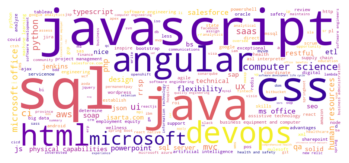

In [21]:
gen_wordCloud(skills_arr)

In [22]:
calc_occ(skills_arr).most_common()

[('sql', 508),
 ('javascript', 490),
 ('java', 387),
 ('css', 340),
 ('angular', 221),
 ('devops', 214),
 ('html', 210),
 ('microsoft', 210),
 ('computer science', 209),
 ('aws', 174),
 ('ci', 174),
 ('saas', 167),
 ('ui', 156),
 ('python', 155),
 ('microsoft office', 155),
 ('', 149),
 ('ux', 146),
 ('mvc', 136),
 ('human resources', 121),
 ('qa', 114),
 ('php', 110),
 ('js', 98),
 ('ms office', 95),
 ('typescript', 91),
 ('flexibility', 90),
 ('salesforce', 89),
 ('design', 88),
 ('etl', 87),
 ('powerpoint', 87),
 ('soap', 86),
 ('rrsp', 81),
 ('restful', 81),
 ('json', 74),
 ('jenkins', 74),
 ('sap', 74),
 ('nice', 72),
 ('sql server', 70),
 ('isarta.com', 70),
 ('solid', 68),
 ('physical capabilities', 68),
 ('technical', 66),
 ('seo', 65),
 ('bs', 62),
 ('business equipment and computer', 62),
 ('pl', 62),
 ('servicenow', 60),
 ('bi', 60),
 ('review', 59),
 ('node', 59),
 ('powershell', 59),
 ('agile', 58),
 (' python', 58),
 ('cms', 57),
 ('amazon', 55),
 ('software engineering',

# Step 3. Retrieving more skills

In [23]:
def merge_compound(nlp_tok):
    result=''
    for child in nlp_tok.children:
        if child.dep_ == "compound" and len([child for child in token.children])==0:
            return nlp_tok.text +' '+child.text
    return nlp_tok.head.text+ ' '+nlp_tok.text
    

In [24]:
def keep_percent(sort_arr, dec_keep):
    length=len(sort_arr)
    keep=length*dec_keep
    final=[]
    for word in sort_arr:
        final.append(word[0])
        if len(final)>=keep:
            break;
    return final
        

## I took the method from [this blog post](https://skeptric.com/extract-skills-2-adpositions/) and adopted it for the task at hand. To extract more skills I:
1. Identified the most popular heads of the skills

2. Retrieved the skills using the following process:
    
    - For each word check whether it is in the set of heads
    
    - If yes, check whether the word has a preposition
    
    - If yes, retrieve the object of this preposition and its leftmost meaningful child (this helps retrieves skills which are made of more than 1 word)
    


<hr/>
<strong>This method is not perfect, it does not retrieve some skills and retrieves a lot of words which are not skills. I created the list of stop words to help solve the second problem, however I could not get rid of non-skills words completely. However, I think the results are good enough, because a lot of useful skills were retrieved. Even if some words do not look exactly like skills they still can help one get a sense of what an employer in a given field is looking for </strong>

### Step 1. Retrieve all heads of skills and then keep only the most popular ones

In [25]:
heads=[]
all_descs=list(df_hard_prepr['description'])
for desc in all_descs:
    nlp_desc=NER(desc.lower()) 
    for token in nlp_desc:
        if any(token.text in skill for skill in better_skills) and token.is_stop==False and token.pos_ not in['PUNCT', 'SPACE', 'AUX']:
                    nlp_add=token
                    while (nlp_add.head.is_stop==True or nlp_add.head.pos_ in ['PUNCT', 'SPACE', 'AUX']) and nlp_add.text!=nlp_add.head.text:
                        nlp_add=nlp_add.head
                    if (nlp_add.head.is_stop==True or nlp_add.head.pos_ in ['PUNCT', 'SPACE', 'AUX']):
                        continue;
                    heads.append(nlp_add.head.text)

In [26]:
bh=[re.sub(r"[^a-z0-9 ]"," ", x) for x in heads ]
bh=[re.sub(r"\s{2,}", " ", x) for x in bh if x!=' ']
head_occ=calc_occ(bh).most_common()
head_best=keep_percent(head_occ, 0.01) #I keep only 1 percent of the most popular heads, it helps refine the next steps of the process

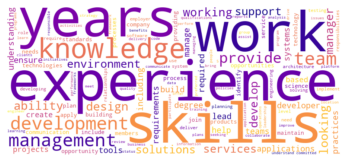

In [27]:
gen_wordCloud(head_best)

In [34]:
len(head_best)

130

In [28]:
one_stops=['experience', 'home', 'pressure', 'detail', 'behalf', 'work', 'ability', 
           'exceptional abilities', 'issues', 'view', 'development team', 'colleagues', 'example', 'regards', 'depth',
          'experience experience', 'line', '80,000', 'request', 'estimates', 'use', 'patients', 'solutions', 'benevity', 
          'customer sucess', 'clarity', 'code', 'key', 'network', 'global team', 'project team', 'support', 
           'incentive plans', 'team process', 'elements', 'disabilities', 'customers', 'life', 'senior management', 
           'new equipment', 'building', 'diversity', 'order', 'employers', 'operations', 'people', 'banking sector', 'vendors',
          'terms', 'high level', 'leaders', 'fit', 'products', 'progress', 'students', 'experience knowledge']
any_stops=['member','members', 'environment', 'candidate', 'candidates', 'ontario', 'canada', 'america', 
           'north', 'relevant', 'individual', 'individuals', 'teams', 'accordance', 'button', 'year', 
           'years', 'manager', 'equity', 'recruitment', 'results', 'staff', 'developer', 'california', 'experts',
          'applicants', 'inclusive', 'inclusion', 'clients', 'those', 'jobs', 'peers', 'toronto', '$', 'expert', 'sun', 
           'massachusetts', 'pennsylvania', 'illinois', 'ann', 'employee', 'employees', 'hours', 'partner', 'partners', 
           'day', 'passionate', 'success', 'daily', 'exist', 'existing', 'mate', 'mates', 'reliable', 'current', 
           'great', 'hands', 'immediate', 'citizenship', 'haves', 'www.cgi.com', 'stakeholders', 'completion',
          'employment', 'conjunction', 'pension', 'common']

In [29]:
other_skills=[]
for one_descr in df_hard_prepr['description']:
    nlp_one=NER(one_descr.lower())
    skills_descr=[]
    for tok in nlp_one:
         if tok.text in head_best:
            for child in tok.rights:
                if child.dep_ == 'prep':
                    for obj in child.children:
                        if obj.dep_ == 'pobj':
                            if len([l for l in obj.lefts])>0:
                                for toadd in obj.lefts:
                                    if toadd.is_stop==False and toadd.pos_ not in ['PUNCT', 'SPACE', 'AUX']:
                                        fs=toadd.text + ' ' + obj.text
                                        if len(list(set(fs.split(' '))&set(any_stops)))==0 and fs not in one_stops and fs not in better_skills:
                                            skills_descr.append(fs)
                                            break;
                            elif obj.is_stop==False and obj.pos_ not in['PUNCT', 'SPACE', 'AUX']:
                                tc=obj.text
                                if  obj.dep_=='compound':
                                    tc=merge_compound(obj)
                                if tc not in better_skills and tc not in one_stops and tc not in any_stops and (len(tc)>1 or tc=='c'):
                                        skills_descr.append(tc)
    other_skills.append(skills_descr)

In [30]:
df_hard_prepr['new_skills']=other_skills
df_final=basic_prepr_skills(df_hard_prepr, 'new_skills')
df_final.head(5)

,title,company,description,position,hard_skills,new_skills
3500,newJava Developer,FirstVibe Technologies INC.,Java Developer1. 5+ years of hands-on developm...,developer,"[core java, java, source control, sql]","[development experience, development environme..."
3501,Entry Level Software Engineer,Enable,Would you like to work in a vibrant environmen...,developer,"[html, css, javascript, gpa, computer science,...","[new features, experienced engineers, career o..."
3502,SQL Developer / Analyst,MCAP,SQL Developer / AnalystMCAP at a GlanceJoining...,developer,"[sql, developer, analyst, ms sql server, ssrs,...","[dynamic rolemcap, governance, consideration, ..."
3503,Junior Web Developer,VertexOne - Remote US and Canada,"At VertexOne, helping utilities provide the be...",developer,"[responsibilitiescode, microsoft, uat, qa, css...","[utility industry, strong skills, oriented des..."
3504,PHP Developer,Vestra Inet,Candidates must have strong experience in back...,developer,"[mvc, php, apache, light]","[end development, php testing, formal developm..."


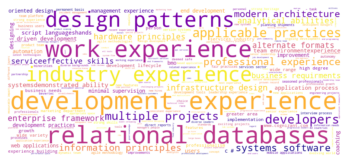

In [31]:
new_skills_arr=np.array(df_final['new_skills'])
new_skills_arr=flat_2d_arr(new_skills_arr)
gen_wordCloud(new_skills_arr)

In [32]:
calc_occ(new_skills_arr).most_common()

[('development experience', 85),
 ('relational databases', 83),
 ('work experience', 78),
 ('design patterns', 64),
 ('industry experience', 60),
 ('applicable practices', 57),
 ('developers', 55),
 ('multiple projects', 52),
 ('professional experience', 51),
 ('systems software', 49),
 ('information principles', 49),
 ('modern architecture', 48),
 ('infrastructure design', 48),
 ('hardware principles', 48),
 ('analytical abilities', 48),
 ('alternate formats', 47),
 ('enterprise framework', 46),
 ('business requirments', 44),
 ('serviceeffective skills', 44),
 ('systemsdemonstrated ability', 44),
 ('team environmentexperience', 44),
 ('script languageshands', 44),
 ('application process', 42),
 ('driven development', 42),
 ('c #', 36),
 ('bmo', 36),
 ('minimal supervision', 36),
 ('automation', 36),
 ('web applications', 35),
 ('improvement', 35),
 ('designing', 34),
 ('end development', 33),
 ('users', 33),
 ('development practices', 33),
 ('management experience', 33),
 ('oriented d

In [33]:
df_final.to_csv('all_skills_2.csv')

## Results:
- As can be seen the resulting skills we extracted are not all soft skills, some of them are just skills without a fixed name, or skills containing more than 1 word (not being compound at the same time). However, the results we achieved are still pretty good because we managed to extract a lot of skills